# Ensemble-Volatility

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [3]:
import random

# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

CCIV


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
import os
import sys
import mysql.connector

HOST="143.244.188.157"
PORT="3306"
USER="patrick-finProj"
PASSWORD="Pat#21$rick"

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [5]:
df = histdailyprice3.copy()

In [6]:
df.head()

,Date,Close,Open,High,Low,Volume
0,2020-09-18,10.25,10.250,9.8200,9.89,564300
1,2020-09-21,9.90,9.960,9.8600,9.86,762700
2,2020-09-22,9.96,9.960,9.8500,9.88,1280700
3,2020-09-23,9.90,9.905,9.7901,9.85,192500
4,2020-09-24,9.85,9.850,9.7500,9.77,605500


In [7]:
returns = 100 * df['Close'].pct_change().dropna()
realized_vol = returns.rolling(5).std()

In [8]:
n = int(len(returns)*0.4)
split_date = returns[-n:].index

# ARCH

In [11]:
from arch import arch_model
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                       ARCH   Log-Likelihood:               -63.1449
Distribution:                  Normal   AIC:                           130.290
Method:            Maximum Likelihood   BIC:                           134.898
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1870  5.026e-02      3.720  1.989e-04 [8.848e-0

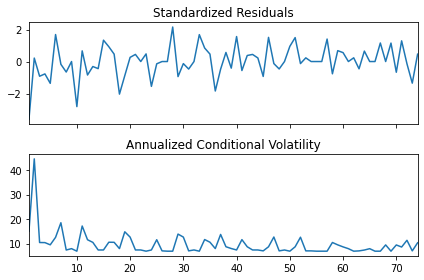

In [12]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

In [13]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)

In [14]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
         best_param = p
arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                       ARCH   Log-Likelihood:               -63.1449
Distribution:                  Normal   AIC:                           130.290
Method:            Maximum Likelihood   BIC:                           134.898
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1870  5.026e-02      3.720  1.989e-04 [8.848e-0

In [15]:
from sklearn.metrics import mean_squared_error as mse

forecast_arch.variance

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
70,0.290980
71,0.507990
72,0.193457
73,0.420035


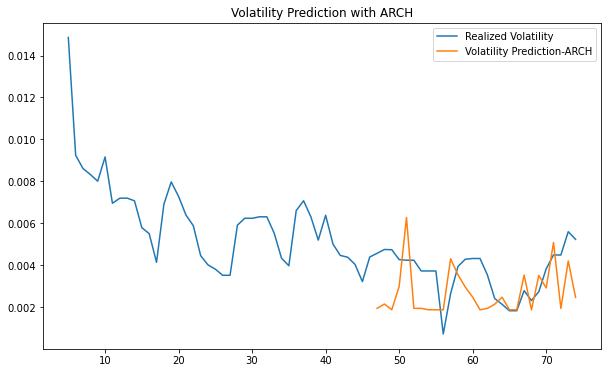

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [17]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0475


# GARCH

In [18]:
garch = arch_model(returns, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                      GARCH   Log-Likelihood:               -55.9186
Distribution:                  Normal   AIC:                           117.837
Method:            Maximum Likelihood   BIC:                           124.749
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:46   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.8476e-03  5.955e-03      1.654  9.818e-02 

In [19]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                      GARCH   Log-Likelihood:               -55.9186
Distribution:                  Normal   AIC:                           117.837
Method:            Maximum Likelihood   BIC:                           124.749
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:47   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.8476e-03  5.955e-03      1.654  9.818e-02 

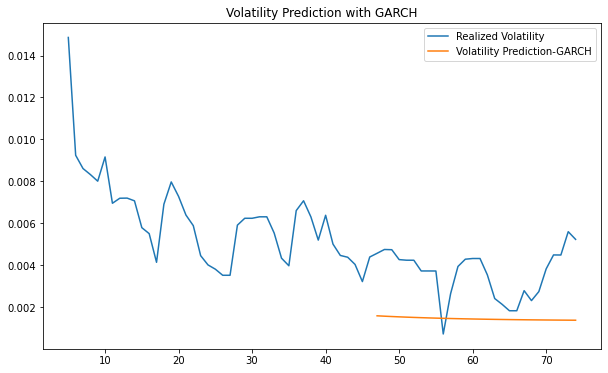

In [20]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [21]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0338


# GJR GARCH

In [22]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(returns, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
             best_param = p, q
gjrgarch = arch_model(returns, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

bic_garch = []

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                  GJR-GARCH   Log-Likelihood:               -55.9186
Distribution:                  Normal   AIC:                           119.837
Method:            Maximum Likelihood   BIC:                           129.053
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:48   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.8546e-03  1.284e-02      0.767      0.443 

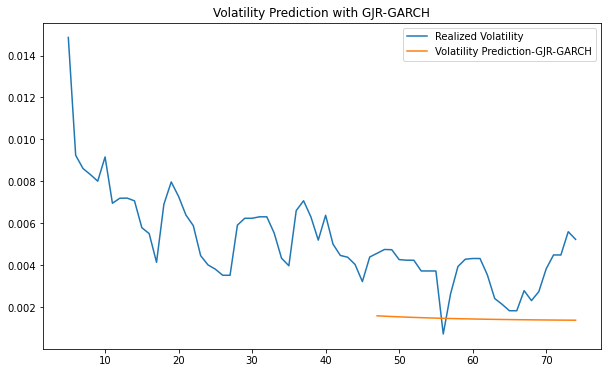

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

In [24]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0338


# EGARCH

In [25]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
    egarch = arch_model(returns, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.014
Vol Model:                     EGARCH   Log-Likelihood:               -50.7702
Distribution:                  Normal   AIC:                           107.540
Method:            Maximum Likelihood   BIC:                           114.453
                                        No. Observations:                   74
Date:                Wed, Jan 05 2022   Df Residuals:                       74
Time:                        15:50:49   Df Model:                            0
                                Volatility Model                               
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
omega      -4.4702e-03  3.216e-05   -139.003     

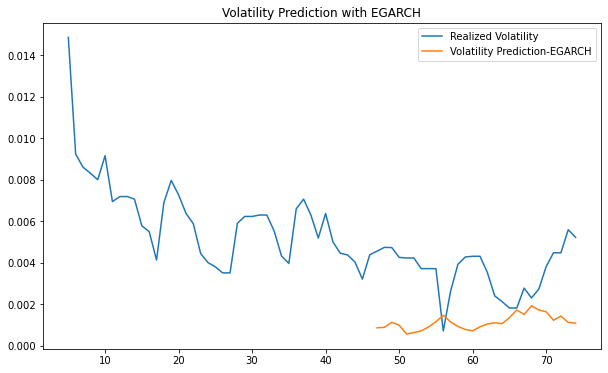

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [27]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0298


# SVR GARCH

In [28]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [29]:
realized_vol = returns.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = returns ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['index']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

## Linear

In [30]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001874


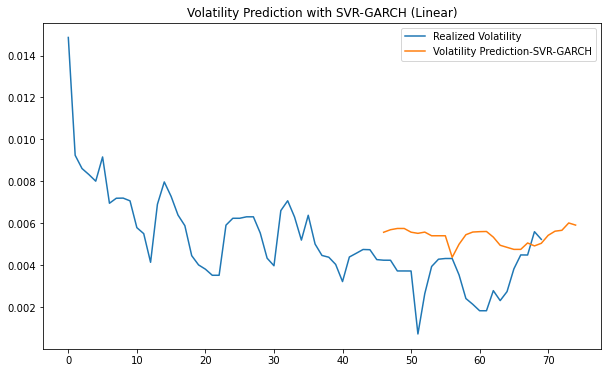

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [32]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001874


## Radial basis function

In [33]:
para_grid ={'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = returns.iloc[-n:].index

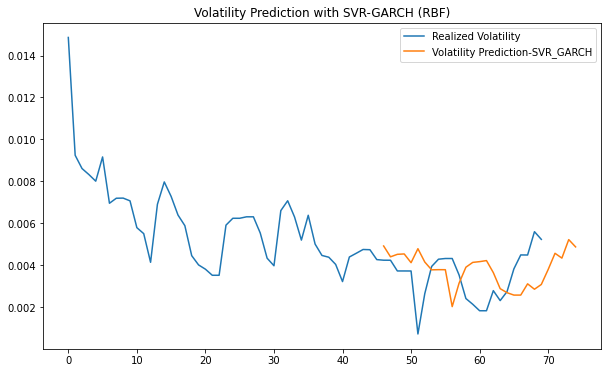

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [35]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000424


## Polynomial Kernal

In [36]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = returns.iloc[-n:].index

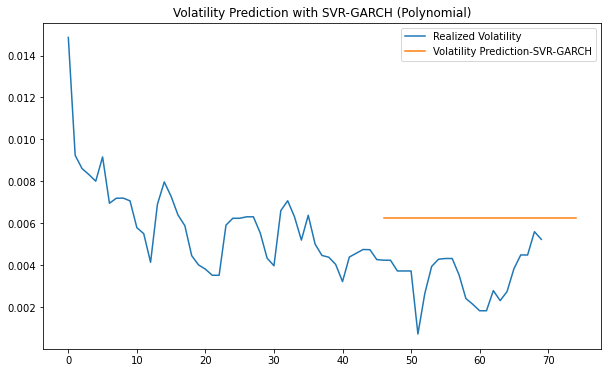

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)', fontsize=12)
plt.legend()
plt.show()

In [38]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.002822


# Neural Networks

In [39]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [500, 1000],
                'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = returns.iloc[-n:].index

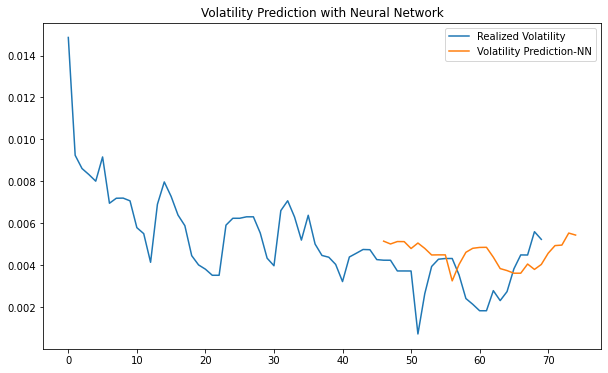

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

In [41]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.001051


## Tensorflow

In [51]:
!python --version

Python 3.9.7


In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

# RSME

In [42]:
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of ARCH model is 0.0475
The RMSE value of GARCH model is 0.0338
The RMSE value of GJR-GARCH models is 0.0338
The RMSE value of EGARCH models is 0.0298
The RMSE value of SVR with Linear Kernel is 0.001874
The RMSE value of SVR with RBF Kernel is  0.000424
The RMSE value of SVR with Polynomial Kernel is 0.002822
The RMSE value of NN is 0.001051
